In [29]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk
import emoji
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')
from keybert import KeyBERT
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer


In [30]:
with open("raw_tables_2023_03_05/raw_tweets", "rb") as raw_timeline_file:
    tweet_df = pd.read_pickle(raw_timeline_file)
    # tweet_df.to_csv('raw_tweets_out.csv')
    print(tweet_df["content"].head(5))

0    I applaud North Carolina’s announcement to exp...
1    I’m so proud to have the Young Men’s Leadershi...
2    Happy Women’s History Month! When women succee...
3                    Stay safe out there, North Texas!
4    Wishing my fellow Texans everywhere a happy Te...
Name: content, dtype: object


In [31]:
def deep_clean_tweet(tweet): # For MAX
    # temp = re.sub("'", "", tweet) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", tweet) #Remove @ sign
    temp = temp.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    temp = re.sub(r"(?:\@| ?\://|https?\://|www)\S+", "", temp) #Remove http links
    temp = re.sub(r'\s*\b(?:https?:\/\/)?(?:www\.)?\S+\.(com|org|gov)\S*\b', ' ', temp)  # remove com/org/gov links
    temp = re.sub(r'\bbit\.ly\/\S*', '', temp) #remove bit.ly links
    temp = re.sub(r'\bow\.ly\/\S*', '', temp) #remove ow.ly links
    temp = re.sub(r'(?<=\d),(?=\d)', '', temp) # remove thousand comma in number string
    temp = ''.join(c for c in temp if c not in emoji.EMOJI_DATA) #Remove Emojis
    temp = " ".join(w.lower() for w in nltk.wordpunct_tokenize(temp) if w.isalnum()) #remove strings that are not alphabetical nor numerical
    return temp


In [32]:
# combined top 10 liked tweets for each user, cleaned
temp = tweet_df[['user_name', 'like_count', 'content']]
temp['like_count'] = pd.to_numeric(temp['like_count'], errors='ignore')
temp = temp.sort_values('like_count',ascending = False).groupby('user_name').head(10)
temp = temp.sort_values(['user_name','like_count'],ascending = True)
temp['concat_content'] = temp[['user_name','content','like_count']].groupby(['user_name'])['content'].transform(lambda x: ','.join(x))
temp.drop_duplicates(subset='concat_content', keep="last", inplace = True)
temp['concat_deep_cleaned'] = temp['concat_content'].map(lambda x: deep_clean_tweet(x))


In [33]:
# get the keyword for each user (one word per user)
kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2') 
#to change other transformers: https://www.sbert.net/docs/pretrained_models.html
def exrtact_keywords(doc):
    return kw_model.extract_keywords(doc,keyphrase_ngram_range=(1, 1),highlight=False,stop_words='english')[0][0]
temp['key_words'] =  temp["concat_deep_cleaned"].apply(exrtact_keywords)
temp.to_csv('keyword.csv')
temp

,user_name,like_count,content,concat_content,concat_deep_cleaned,key_words
4683940,AlLawsonJr,764,Great night supporting my good friend and our ...,After voting AGAINST disaster relief that woul...,after voting against disaster relief that woul...,leadership
1716231,AlbioSiresNJ,59,It's an honor to earn the support of NJ's lead...,"With the primary election behind us, it’s time...",with the primary election behind us it s time ...,democrats
4728346,AndrewJBates46,23830,Dark Brandon is crushing it https://t.co/w0L8x...,This is an incredibly important moment: in jus...,this is an incredibly important moment in just...,afghanistan
4957110,Atrios,8405,lol https://t.co/AAAPmgVCAG,"who does the world owe this debt to,theonion.c...",who does the world owe this debt 2005 this guy...,liberals
1309862,AustinScottGA08,8379,"Guilty until proven innocent. That, my friends...",The CCP's bid to buy cropland in the United St...,the ccp s bid to buy cropland in the united st...,cropland
...,...,...,...,...,...,...
2266120,sethmoulton,324925,"As the Representative of Salem, MA, I can conf...",Just came out of the House briefing by the Dep...,just came out of the house briefing by the dep...,deputy
3447654,stevebenen,37388,Mulvaney said Dems are only seeking Trump's ta...,Boebert is currently co-sponsoring two constit...,boebert is currently co sponsoring two constit...,amendments
3659971,thegarance,64541,Washington Postal Workers Defy USPS Orders And...,"Thank u, next https://t.co/opvIcdLnW6,People o...",thank u next often imagine themselves being wi...,trump
2828611,timkaine,83657,"I wanted to be first at my polling place, but ...",Charlottesville violence was fueled by one sid...,charlottesville violence was fueled by one sid...,racism


In [34]:
# show the highlighted keyword in the context of original cleaned concat_content
def exrtact_keywords_highlighted(doc):
    return print(kw_model.extract_keywords(doc,keyphrase_ngram_range=(1, 1),highlight=True,stop_words='english'))
temp["concat_deep_cleaned"].head(5).apply(exrtact_keywords_highlighted)

after voting against disaster relief that would help sw fl my opponent is now groveling to and asking for pitiful 
leadership means doing your job when it is in front of you not asking someone else to do your job for you fl02 am 
honored to have received the endorsement of one of the nation leading civil rights attorneys throughout our careers
we have worked to right the wrongs of the past and end racial injustices criminaljusticereform starts with your 
vote august 18 2020 al lawson and approve this message teambiden commend fifth third bank for standing up and doing
the right thing to support educational opportunities for florida kids who need them most our great state will be 
the better for as someone who grew up in the heart of segregation and has first hand accounts of racial inequality 
and injustice it warms my heart to see the remove the confederate monument in hemming park and throughout the city 
commend the citizens of jacksonville for pushing despite calls from doctors advocates and even insurance companies 
to reopen aca enrollment donald trump is once again blocking what best for the american people bill russell was 
great man on and off the court rest in peace rest in power senate democrat voted to fight inflation and to cut 
prescription drug costs every senate republican voted for more inflation and higher drug costs the choice is clear 
remember in november agenda for black america put forth by is what our nation needs we must work together to 
address health disparities inequities in our justice system amp work to advance economic mobility in the black 
community lifteveryvoice teamjoe fl05 night supporting my good friend and our next governor fl02

[('leadership', 0.5399), ('democrat', 0.4755), ('criminaljusticereform', 0.4436), ('injustices', 0.4254), ('injustice', 0.417)]


with the primary election behind us it time for all democrats to come together to re elect senator booker and 
restore true leadership to the white house by electing as our next president today is election day remember there 
are two ways to votebidenbookersires mail your ballot back today or drop it at your county clerk or secure dropbox 
vote in person until 8pm at one of the polling places listed here it time for all democrats to come together to re 
elect senator booker and restore true leadership to the white house by electing as our next president this morning 
joined and members of our dem congressional delegation to officially kick off the 2020 we must unite our party 
behind and spoke about why this election is so critical helped pass the affordable care act and now working to 
expand obamacare and protect it from republican attacks votebidenbookersires would like to thank democrats from 
across hudson essex union and bergen counties for their support in this unprecedented election am honored to have 
the opportunity to continue to serve the people of the 8th district member of the congressional gun violence 
prevention task force working to take guns off our streets with new assault weapons ban universal background checks
and more votebidenbookersires would like to thank democrats from across hudson essex union and bergen counties for 
their support in this unprecedented election even when confronted with the need to vote in new ways the people made
their voices heard and thank them you to and the entire hoboken city council for their support council members 
doyle and falco an honor to earn the support of nj leading democrats who have seen my record of standing up for our
values and delivering for the people represent up close

[('democrats', 0.6132), ('election', 0.5858), ('ballot', 0.5465), ('senator', 0.5054), ('vote', 0.5048)]


this is an incredibly important moment in just over months after taking office has now won the confirmation of more
black women as circuit court judges than any president in american history new 19000 people were evacuated from 
afghanistan in the 24 hours between am on 24 and am on 25 we ve now evacuated 82300 people since 14 and 87900 since
july wait republicans are now attacking us for stopping fentanyl trafficking you re either on the side of the mob 
or the side of the police and it sickening to see the new attacks on the fbi threatening the life of law 
enforcement agents and their families has restored honor dignity and class to the white house briefing room psaki 
was consistently prepared effective in communicating for the president and even when sparring with media members 
always respectful cornyn is praising her performance the wsj ed board is praising her love of america moderates in 
both parties are dismissing debunked fringe attacks and in gallup she tied with roberts for the most popular 
nominee in recent history good day to be judge jackson brutal fact check of aarp said this has been fact checked 
repeatedly and shown to be lie in fact this bill saves medicare nearly 300 billion by lowering the price of drugs 
only drug companies would say that saving money is bad thing regulations regarding train safety were changed during
the trump administration this particular railroad and others lobbied president trump to dismantle an obama era rule
that would have required railroads to update their braking systems it was biden and his team patience and close 
consultation with european allies that has led to the extraordinary unity now on display brandon is crushing it

[('afghanistan', 0.3875), ('evacuated', 0.3624), ('judges', 0.3282), ('republicans', 0.3195), ('american', 0.309)]


who does the world owe this debt 2005 this guy wrote believe that liberals loathe the iraq war because they loathe 
bush rather than vice versa chait and yglesias were the people who legitimized the iraq war it hard not to joke 
about qanon because so much of it is absurd but at heart it movement dedicated to the mass executions of political 
enemies he spent years selling his customers product that will never exist very funny genre is sure am garbage 
person but have you considered that other people are garbage too real clear politics is partisan republican 
propaganda outfit is something some of us tried to explain like 15 years ago my guy you just had paternity leave 
lol

[('liberals', 0.5384), ('bush', 0.4405), ('iraq', 0.4168), ('debt', 0.3971), ('partisan', 0.3642)]


the ccp bid to buy cropland in the united states is clearly nefarious attempt to manipulate our food supply it is 
in our nation best interest not to allow this to happen than 2yrs ago my friend survived shooting yesterday he was 
barred by my dem colleagues from testifying at house judiciary committee hearing on new liberal gun control 
legislation they didn want to hear his 2ndamendment support more clowns showed up today to once again delay 
disaster relief for the states and farmers devastated by the storms of 2018 this bill will pass the house next week
and president trump will sign it ga08 mark meadows betrayed trump and america and supported pelosi and dems to 
protect obamacare nation is in recession has record inflation is over 30 trillion in debt and this is how and 
democrats are spending your tax dollars this is taxpayer abuse evening reiterated that the state of our union is 
strong our economy continues to grow more americans are back to work workers farmers amp businesses have more level
playing field in our global markets sotu amp deny congress chance to vote on proposal it will pass the schumer 
pelosi games are hurting fed workers allowing criminal activity along our border amp holding up disaster assistance
they say they want to open the gov then let vote how did afghanistan fall happen in mere hours congress needs to 
know the facts must call congress back now tough questions need to be asked amp answered anything else is nothing 
other than partisan protection of biden regardless of the consequences to america pelosi is opening liquor store in
the house where members can buy alcohol with their taxpayer funded mras all while americans are struggling to pay 
for food outrageous until proven innocent that my friends is the way they do it in china venezuela cuba and against
in the house of representatives under

[('cropland', 0.5238), ('farmers', 0.3925), ('states', 0.3355), ('gov', 0.322), ('state', 0.3003)]


4683940    None
1716231    None
4728346    None
4957110    None
1309862    None
Name: concat_deep_cleaned, dtype: object

In [35]:
# doc = 'today i will object to the certification of some states electoral college votes i believe the american people deserve a debate and investigation into voting irregularities during the 2020 election china pledged to preserve the one country two systems framework through 2047 well give or take 27 years hongkong oppose any impeachment efforts put forth by the house president trump has announced a smooth orderly amp seamless transfer of power his team is ensuring the biden harris administration has everything they need to assume office there is no need to create a further divide as our country deals with yet another viral outbreak from china let s also keep in mind fentanyl from chinese chemical producers kills tens of thousands of americans yearly the chinese communist party is a serious threat to our health and safety let s start acting like it it s not just that ccp chinese communist party hid coronavirus from world and did little to stop spread primary problem is ccp s flouting of environmental and health standards in order to undercut competing economies that create conditions for succession of outbreaks one in five households receiving food stamps had more than 100k in assets tens of thousands with more than 1 million in assets we tried to stop abuse but democrats refuse any reform they say we re depriving millionaires of food stamps trump admin is addressing problem complete and total agreement i joined this letter asking justice department to provide details of chinese communist party s propaganda appearing in and other outlets ccp hid virus from world allowed it to get out of hand and at the same time threatens to withhold medication to treat coronavirus ultimate result of this situation will be to move drug manufacturing out of china as we are doing with other industries for our own protection read my piece in the federalist president trump s emergency declaration to secure the southern border is necessary and legal china russia iran and powerful mexican drug cartels sometimes working together are threatening americans'
# kw_model.extract_keywords(doc,keyphrase_ngram_range=(1, 1),highlight=True,stop_words='english')

In [36]:
#get gloVe embeeding for the keyword of each user
import gensim.downloader as api
model = api.load('glove-wiki-gigaword-100')
def get_embedding(word):
    if word in model.key_to_index:
        embedding = model[word]
        return embedding
    else:
        return None

#Exclude users with Null embedding. i.e. the keyword for that user is NOT in gloVe dataset
temp['embedding'] = temp['key_words'].apply(get_embedding)
temp2 = temp[~temp['embedding'].isnull()]

# get username and profiles (including influencers)
with open('user_lookup.json') as json_file:
    data = json.load(json_file)
# filtered_index = [k for k in data if data[k] in house_senate_list]
data = pd.DataFrame.from_dict({k:[v] for k,v in data.items()}).transpose()
data.columns = ['user_name']
data = data.reset_index().drop(columns = ['index'])
profile = np.loadtxt('user_profile_151')
profiles = pd.DataFrame(np.matrix(profile))
profiles['profile'] = profiles.values.tolist()
profiles =  pd.DataFrame(profiles['profile'])
profiles = profiles.reset_index().drop(columns = ['index'])
temp_profile = pd.concat([data, profiles], axis=1)

# get the user profiles and names for those who have ''
combined = temp_profile.merge(temp2, left_on='user_name', right_on='user_name',how = 'inner')



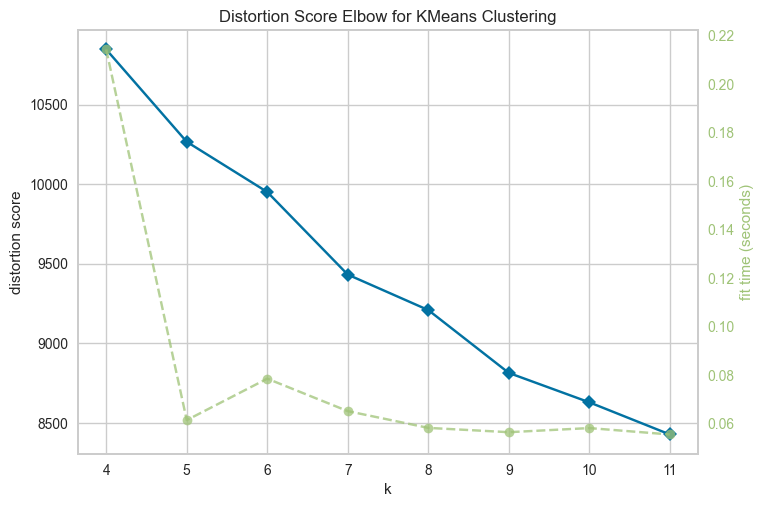

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [37]:
#determine optimal number of clusters using elbow method. 

# default criteria: distortion, which computes the sum of squared distances from each point to its assigned center
# silhouette score calculates the mean Silhouette Coefficient of all samples,
# while the calinski_harabasz score computes the ratio of dispersion between and within clusters.
X = np.array(combined['embedding'].tolist())
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, metric = 'distortion',k=(4,12))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


## Plot the uer profiles in 2d(5d->2d using tsne), colored by their keyword. Keyword embedding is clustered using kmeans

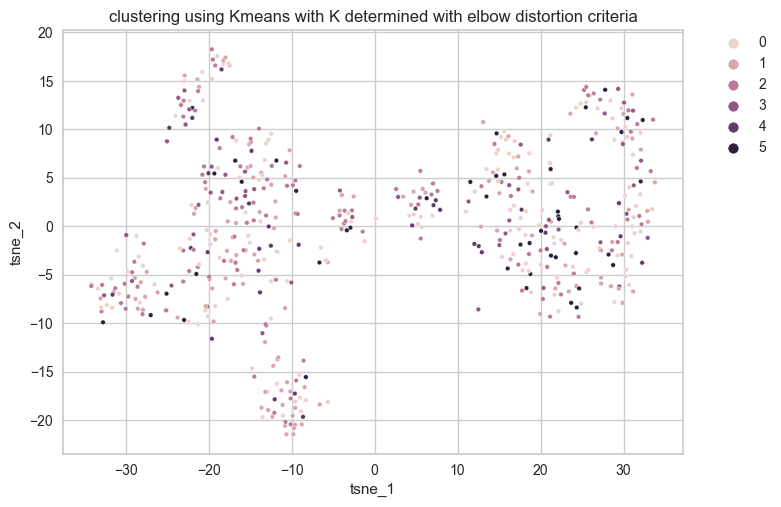

In [39]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_
km_centroids  = kmeans.cluster_centers_
def get_km_centroid( label):
    return  km_centroids[label]
combined['label_elbow'] = labels
combined['elbow_centroid_k'] = combined['label_elbow'].apply(get_km_centroid)

profile = np.array(combined['profile'].tolist())
profiles = pd.DataFrame(np.matrix(profile))
profiles['profile'] = profiles.values.tolist()
profiles =  pd.DataFrame(profiles['profile'])
profiles = profiles.reset_index().drop(columns = ['index'])

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(profile)
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label_elbow':combined['label_elbow']})
fig, ax = plt.subplots(1);
sns.scatterplot(x='tsne_1', y='tsne_2', data= tsne_result_df,hue = 'label_elbow', ax=ax,s=11 );

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0);
ax.set_title('clustering using Kmeans with K determined with elbow distortion criteria');

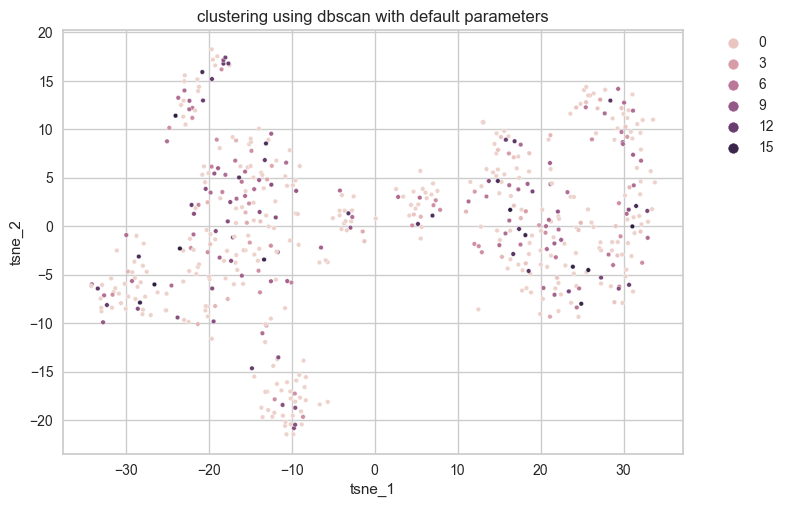

In [40]:
# clustering with dbscan
from sklearn.cluster import DBSCAN
db_clustering = DBSCAN().fit(X)
db_labels = db_clustering.labels_
def get_db_centroid(label):
    return  db_centroids[label]

combined['label_dbscan'] = db_labels
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label_dbscan':combined['label_dbscan']})
fig, ax = plt.subplots(1);
sns.scatterplot(x='tsne_1', y='tsne_2', data= tsne_result_df,hue = 'label_dbscan', ax=ax,s=11 );
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0);
ax.set_title('clustering using dbscan with default parameters');

In [41]:
combined.head()

,user_name,profile,like_count,content,concat_content,concat_deep_cleaned,key_words,embedding,label_elbow,elbow_centroid_k,label_dbscan
0,AlLawsonJr,"[1.362959623336792, -1.1544591188430786, 1.352...",764,Great night supporting my good friend and our ...,After voting AGAINST disaster relief that woul...,after voting against disaster relief that woul...,leadership,"[0.057674, -0.051283, -0.0069192, -0.060853, -...",2,"[-0.011010647, 0.06785132, 0.08461544, -0.2037...",-1
1,AlbioSiresNJ,"[-2.3794515132904053, -1.0317786931991577, -3....",59,It's an honor to earn the support of NJ's lead...,"With the primary election behind us, it’s time...",with the primary election behind us it s time ...,democrats,"[-0.77282, 0.82904, 0.57102, -0.73313, 0.38599...",0,"[-0.36562952, 0.3977483, 0.5913871, -0.4605623...",0
2,AndrewJBates46,"[1.9340037107467651, 0.2336748242378235, 0.061...",23830,Dark Brandon is crushing it https://t.co/w0L8x...,This is an incredibly important moment: in jus...,this is an incredibly important moment in just...,afghanistan,"[-0.94272, 1.0076, 0.76593, -0.024247, 0.84907...",2,"[-0.011010647, 0.06785132, 0.08461544, -0.2037...",-1
3,Atrios,"[0.8065455555915833, 1.1333773136138916, 1.689...",8405,lol https://t.co/AAAPmgVCAG,"who does the world owe this debt to,theonion.c...",who does the world owe this debt 2005 this guy...,liberals,"[-0.37247, 0.64951, 0.41108, -0.55233, 0.15814...",0,"[-0.36562952, 0.3977483, 0.5913871, -0.4605623...",-1
4,AustinScottGA08,"[0.4940970838069916, 1.221016526222229, -0.739...",8379,"Guilty until proven innocent. That, my friends...",The CCP's bid to buy cropland in the United St...,the ccp s bid to buy cropland in the united st...,cropland,"[-0.045154, 0.24295, 0.55183, 0.26933, -0.2162...",1,"[0.114749804, 0.0038250089, 0.16947311, -0.193...",-1
